In [ ]:
import sklearn, pandas, numpy, urllib, zipfile
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tweets = pandas.read_csv('Tweets.csv')
tweets.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [3]:
# Modelle alakası olmayan kolonları sildik
del tweets['tweet_coord']
del tweets['airline_sentiment_gold']
del tweets['negativereason_gold']

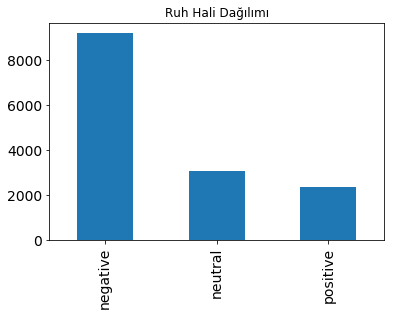

In [4]:
tweets.airline_sentiment.value_counts().plot(kind='bar', title='Ruh Hali Dağılımı', fontsize=14)

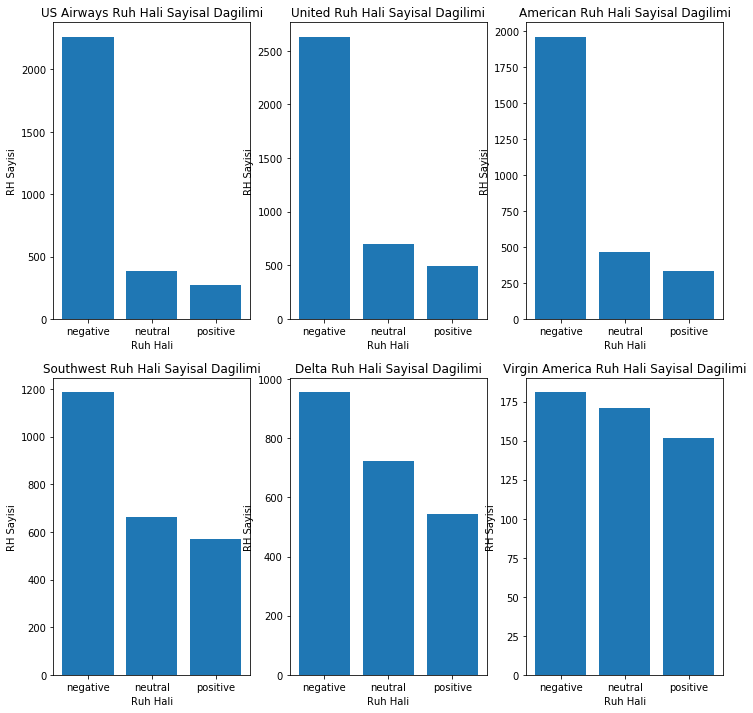

In [5]:
def plot_sub_sentiment(havalimani):
    df=tweets[tweets['airline']==havalimani]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index, count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('RH Sayisi')
    plt.xlabel('Ruh Hali')
    plt.title(havalimani+' Ruh Hali Sayisal Dagilimi')
    
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

    Yukarıdaki çizimlerde ilk 3 havalimanı ile ilgili ruh halinin
    dağılımının negatif eğilimli, sonraki 3ünde ise daha dengeli 
    olduğu görülmekte.

In [6]:
def olumsuz_sayisi(havalimani):
    
    if havalimani == 'Tum':
        df = tweets
    else:
        df = tweets[tweets['airline'] == havalimani]
    
    # Toplam olumsuz yorum sebeplerinin sayisini hesapladık    
    count = dict(df['negativereason'].value_counts())
    
    # Aynı değerleri eledik ve boş değerleri temizledik
    ozgun_degerler = list(tweets['negativereason'].unique())
    ozgun_degerler = [x for x in ozgun_degerler if str(x) != 'nan']
    
    # Temizlenen verilerle yeni bir tablo oluşturduk
    reasons_table = pandas.DataFrame({'Reasons':ozgun_degerler})
    
    # Olumsuz yorumlara sayilarini ekledik
    reasons_table['count'] = reasons_table['Reasons'].apply(lambda x: count[x])
    return reasons_table

def plot_reason(havalimani):
    """Girilen havalimanindaki olumsuz yorum sebeplerini ve sayilarini hesaplar
    ve çizer."""
    
    df = olumsuz_sayisi(havalimani)
    count = df['count']
    Index = range(1, (len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Sayi')
    plt.xlabel('Sebep')
    plt.title(havalimani + " Havalimani Sikayet Dagilimlari")

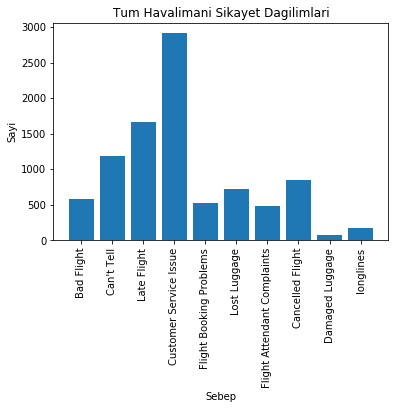

In [7]:
plot_reason('Tum')

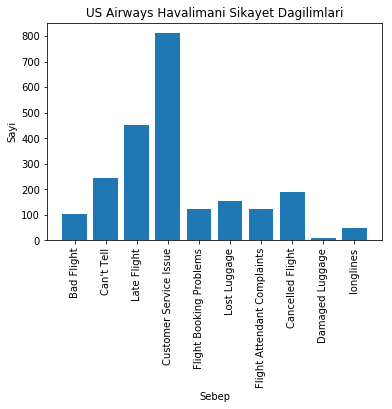

In [8]:
plot_reason('US Airways')

In [9]:
from wordcloud import WordCloud, STOPWORDS

In [10]:
# Negatifleri tweetlerin oldugu sonuclari aldik.
df = tweets[tweets['airline_sentiment']=='negative']

# Tum tweetleri aralarinda ' ' karakteri olacak sekilde birlestirdik
words = ' '.join(df['text'])

# Link, retweet ve tag olmayan kelimeleri ayni sekilde birlestirdik.
cleaned_word = ' '.join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

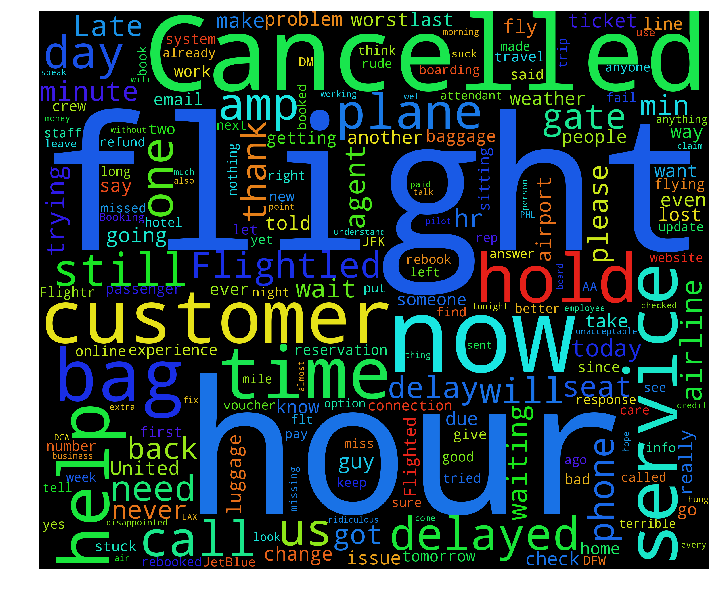

In [11]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

    Görüldüğü üzere negetif tweetlerin çoğunda iptal edildi, uçuş
    saat kelimeleri geçmiş. Buradan kolaylıkla yolcuların gecikmeli
    veya iptal edilen uçuşlar ile ilgili yakındıklarını çıkarabiliriz
    
# Ön hazırlık ve Sınıflandırma

    Verilerin analizi burada bitiyor. Sonraki kısımda modelin 
    verileri daha iyi öğrenebilmesi için verileri hazırlayacağız. 

In [12]:
import re
import nltk
from nltk.corpus import stopwords

# Kelimeleri indirmek icin 1 kereye mahsus calistirilmali
# nltk.download() 

In [13]:
def tweet_to_words(raw_tweet):
    """
        Tweetteki anlamli kelimeleri cikartir.
    """
    # Sadece harf iceren karakter topluluklarini aldik
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet) 
    
    # OLusan stringi kucuk harflere cevirip kelimelere ayirdik
    words = letters_only.lower().split()     
    
    # Ingilizcedeki and, the gibi kelimelerin veri olarak bir degeri yok
    # Gereksiz olan kelimeleri çıkarttık
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    
    return( " ".join( meaningful_words )) 

In [14]:
def clean_tweet_length(raw_tweet):
    """
        Anlamli kelimeleri cikartir ve uzunlugunu dondurur.
    """
    # Sadece harf iceren karakter topluluklarini aldik
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet)    
    
    # OLusan stringi kucuk harflere cevirip kelimelere ayirdik 
    words = letters_only.lower().split()
    
    # Gereksiz olan kelimeleri çıkarttık
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    
    return(len(meaningful_words)) 

In [15]:
# Olumsuz tweetleri 0 digerlerini 1 olarak isaretledik
tweets['sentiment'] = tweets['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [16]:
tweets['clean_tweet'] = tweets['text'].apply(lambda x: tweet_to_words(x))

In [17]:
# Temizlenen tweetlerin uzunluklarini tabloya ekledik
tweets['Tweet_length'] = tweets['text'].apply(lambda x: clean_tweet_length(x))

In [18]:
# Eldeki verileri egitim ve test verileri olarak ayirdik
train, test = train_test_split(tweets, test_size=0.2,random_state=42)

In [19]:
# Egitim ve test verilerini yapayzeka modeline verebilmek
# icin listeye aktardik
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
    
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer listedeki kelimeleri numaralar ile ifade etmemizi sagliyor
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
print(train_features[0])
test_features=v.transform(test_clean_tweet)

  (0, 3506)	1
  (0, 7604)	1
  (0, 8849)	1
  (0, 11008)	1
  (0, 7185)	1
  (0, 10884)	1


# Sınıflandırma

* LogisticRegression
* KNeighborsClassifier
* SVC
* DecisionTreeClassifier
* RandomForestClassifier
* AdaBoostClassifier
* GaussianNB

### Bazı Sınıflandırma Modellerinin Görselleri



                    
![Logistic Regression](http://mlpy.sourceforge.net/docs/3.5/_images/elasticnetc.png "Logistic Regression")

                    Logistic Regression
       
                    
![KNeighborsClassifier]( http://scikit-learn.org/stable/_images/sphx_glr_plot_classification_thumb.png "KNeighborsClassifier")
                    
                    KNeighbors Classifier
                    
![SVC](https://i.stack.imgur.com/pPraK.png "SVC")

                    SVC (Support Vector Classifier)

![Decision Tree Classifier](http://nghiaho.com/wp-content/uploads/2012/02/multivariate_decision_tree1.png "Decision Tree Classifier")
                    
                    Decision Tree Classifier
                    
![Random Forest Classifier](https://i.stack.imgur.com/gsrWe.gif "Random Forest Classifier")

                    Random Forest Classifier

    
    Hazırladığımız verileri sklearnin gelişmiş yapısı sayesinde çaba
    sarfetmeden çeşitli sınıflandırma modellerinde kullanabiliriz.
    

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

    
    Aşağıda yapayzeka modellerini öğrenme oranı, tekrar sayısı gibi gerekli
    değerleriyle tanımladık.    


In [22]:
Classifiers = [
    LogisticRegression(C=0.000000001, solver='liblinear', max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

    Ardından fit() metoduyla modelleri eğittik ve predict() metoduyla test
    verilerinide kullanarak doğruluk oranını ölçtük.

In [23]:
# Kelimelerin sayisal ifadelerini diziye cevirdik
dense_features = train_features.toarray()
dense_test= test_features.toarray()

Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print(classifier.__class__.__name__+" dogruluk orani: "+str(accuracy))    

LogisticRegression dogruluk orani: 0.645150273224
KNeighborsClassifier dogruluk orani: 0.589139344262
SVC dogruluk orani: 0.645150273224
DecisionTreeClassifier dogruluk orani: 0.75956284153
RandomForestClassifier dogruluk orani: 0.812841530055
AdaBoostClassifier dogruluk orani: 0.785519125683
GaussianNB dogruluk orani: 0.572404371585


    
    Artık eğittiğimiz modelin predict() metoduna tweetleri hazırlayıp vererek 
    negatif içerikli olup olmadığını tahmin ettirebiliriz.
    

In [25]:
random_forest_classifier = Classifiers[4]
tahmin = random_forest_classifier.predict(test_features[:4])

In [26]:
tahmin

array([1, 0, 0, 1])